In [4]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms

Load Training Data ~ 300 images

In [40]:
transform = transforms.Compose([transforms.Resize(256),
                                #transforms.CenterCrop(256),
                                transforms.ToTensor()])
train_dataset = datasets.ImageFolder(
        'dataset/train_images',
        transform=transform)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=1)

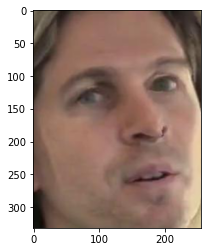

In [43]:
#Testing face load with first image
import matplotlib.pyplot as plt
images, labels = next(iter(train_dataloader))
plt.imshow(images[0].permute(1, 2, 0))

In [ ]:
class XceptionNet(nn.Module):
    def __init__():
        